# Process recount2 data
This notebook does the following:

1. Select template experiment. This template experiment will be used in the next [notebook](2_identify_generic_genes_pathways.ipynb) to simulate experiments with the same experimental design but testing a different biological process.


2. Download and process SRA data in recount2
  
  2a. Download SRA data in recount2 as RangedSummarizedExperiment (rse) object for each project id provided. Raw reads were mapped to genes using Rail-RNA, which includes exon-exon splice junctions. RSE contains counts summarized at the **gene level** using the **Gencode v25 (GRCh38.p7, CHR) annotation** as provided by Gencode.
  
  2b. These rse objects return [coverage counts](https://www.bioconductor.org/packages/devel/workflows/vignettes/recountWorkflow/inst/doc/recount-workflow.html) as   opposed to read counts and therefore we need to apply [scale_counts](https://rdrr.io/bioc/recount/man/scale_counts.html) to scale by **sample coverage** (average number of reads mapped per nucleotide)
  
  2c. DESeq performs an internal normalization where geometric mean is calculated for each gene across all samples. The counts for a gene in each sample is then divided by this mean. The median of these ratios in a sample is the size factor for that sample. This procedure corrects for **library size** (i.e. sequencing depth = total number of reads sequenced for a given sample) and RNA composition bias. DESeq expects [un-normalized](http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#input-data) data.


3. Train VAE on recount2 data

In [10]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [11]:
import os
from ponyo import utils, train_vae_modules
from generic_expression_patterns_modules import process

In [12]:
# Set seeds to get reproducible VAE trained models
process.set_all_seeds()

### Set parameters for data processing

Most parameters are read from `config_filename`. We manually selected bioproject [SRP012656](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE37764) as the template experiment, which contains primary non-small cell lung adenocarcinoma tumors and adjacent normal tissues of 6 never-smoker Korean female patients with 2 replicates each.

In [13]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

# Read in config variables
config_filename = os.path.abspath(
    os.path.join(base_dir, "configs", "config_human_general.tsv")
)

params = utils.read_config(config_filename)

local_dir = params["local_dir"]
dataset_name = params["dataset_name"]

# File that contains gene ranks identified by Crow et. al.
DE_prior_filename = params['reference_gene_filename']

# Template experiment ID
project_id = params['project_id']

# Output file: pickled list of shared genes(generated during gene ID mapping)
shared_genes_filename = params['shared_genes_filename']

# Output files of recount2 template experiment data
raw_template_filename = params['raw_template_filename']
mapped_template_filename = params['mapped_template_filename']
processed_template_filename = params['processed_template_filename']

# Output files of recount2 compendium data
raw_compendium_filename = params['raw_compendium_filename']
mapped_compendium_filename = params['mapped_compendium_filename']
normalized_compendium_filename = params['normalized_compendium_filename']

# Output file: pickled scaler (generated during compendium normalization)
scaler_filename = params['scaler_filename']

### Download template experiment's expression data and generate raw template data file

In [14]:
# Directory where the downloaded files of template experiment will be saved into
template_download_dir = os.path.join(local_dir, "template_download")

# Make sure this directory already exists
os.makedirs(template_download_dir, exist_ok=True)

In [15]:
%%R -i project_id -i template_download_dir -i raw_template_filename -i base_dir

source(paste0(base_dir, '/generic_expression_patterns_modules/download_recount2_data.R'))

get_recount2_template_experiment(project_id, template_download_dir, raw_template_filename)

Loading objects:
  rse_gene


### Download all recount2 SRA data

In [7]:
# Directory where the recount2 SRA data files are saved into
compendium_download_dir = os.path.join(local_dir, "compendium_download")
# Make sure this directory already exists
os.makedirs(compendium_download_dir, exist_ok=True)

metadata_dir = local_dir

In [8]:
%%R -i metadata_dir -i compendium_download_dir -i base_dir

source(paste0(base_dir, '/generic_expression_patterns_modules/download_recount2_data.R'))

download_recount2_sra(metadata_dir, compendium_download_dir)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:12:41 downloading the metadata to /tmp/Rtmpu2prTH/metadata_clean_sra.Rdata

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'https://github.com/leekgroup/recount-website/blob/master/metadata/metadata_clean_sra.Rdata?raw=true'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Content type 'application/octet-stream'
  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2531337 bytes (2.4 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:13:01 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/DRP000987

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/DRP000987/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 14467581 bytes (13.8 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 13.8 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-pa

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:13:50 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/DRP001797

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/DRP001797/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 29374628 bytes (28.0 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 28.0 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-pa

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1784989 bytes (1.7 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:15:12 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/DRP002721

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/DRP002721/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1771794 bytes (1.7 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:15:32 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/ERP000992

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/ERP000992/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 3461999 bytes (3.3 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 3.3 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packa

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 4440076 bytes (4.2 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 4.2 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:15:55 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/ERP001942

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/ERP001942/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packa

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 3.1 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:17:05 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/ERP003460

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/ERP003460/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 3254453 bytes (3.1 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packa

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 4.9 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:17:46 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/ERP003984

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/ERP003984/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1814189 bytes (1.7 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packa

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:18:08 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/ERP004270

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/ERP004270/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2042617 bytes (1.9 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:18:10 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:18:37 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/ERP004683

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/ERP004683/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2069719 bytes (2.0 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:18:39 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:19:11 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/ERP006077

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/ERP006077/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 16568254 bytes (15.8 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 15.8 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-pa

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 5567552 bytes (5.3 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 5.3 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:19:44 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/ERP006662

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/ERP006662/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packa

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 17.2 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:20:14 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/ERP007170

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/ERP007170/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2365246 bytes (2.3 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-pack

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2406131 bytes (2.3 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:20:45 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/ERP008834

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/ERP008834/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2175418 bytes (2.1 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 4.7 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:21:44 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/ERP009612

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/ERP009612/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2400313 bytes (2.3 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packa

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 11.7 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:22:17 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/ERP010177

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/ERP010177/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 3321109 bytes (3.2 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-pack

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2858547 bytes (2.7 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:22:46 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/ERP011282

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/ERP011282/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2635097 bytes (2.5 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 4546202 bytes (4.3 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:23:15 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP000542

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP000542/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1796028 bytes (1.7 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1886672 bytes (1.8 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:24:03 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP001349

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP001349/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1913019 bytes (1.8 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2507724 bytes (2.4 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:24:48 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP002001

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP002001/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1753074 bytes (1.7 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:25:10 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP002306

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP002306/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1961176 bytes (1.9 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:25:11 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:25:32 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP002915

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP002915/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 3790101 bytes (3.6 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:25:35 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 3057788 bytes (2.9 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:26:05 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP004042

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP004042/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1820463 bytes (1.7 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:26:26 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP005309

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP005309/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1807605 bytes (1.7 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:26:27 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 11.0 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:27:01 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP006674

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP006674/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2048854 bytes (2.0 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-pack

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:27:18 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP007169

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP007169/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2284028 bytes (2.2 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:27:20 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:27:54 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP007498

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP007498/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2403851 bytes (2.3 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:27:55 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:28:23 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP007819

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP007819/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1915958 bytes (1.8 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:28:24 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2688345 bytes (2.6 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:28:47 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP008258

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP008258/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1771171 bytes (1.7 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:29:04 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP008746

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP008746/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2506387 bytes (2.4 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:29:06 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:29:25 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP009251

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP009251/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2507203 bytes (2.4 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:29:26 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 5.0 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:29:51 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP009455

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP009455/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1724015 bytes (1.6 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packa

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:30:16 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP010041

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP010041/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2394059 bytes (2.3 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:30:17 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:31:08 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP010384

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP010384/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2080862 bytes (2.0 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:31:10 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:31:26 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP010943

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP010943/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1964597 bytes (1.9 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:31:27 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:31:46 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP011369

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP011369/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2108794 bytes (2.0 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:31:48 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2581935 bytes (2.5 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:32:14 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP011977

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP011977/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1896487 bytes (1.8 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:32:34 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP012461

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP012461/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 11502224 bytes (11.0 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:33:02 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_dow

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:33:24 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP012656

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP012656/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 5841450 bytes (5.6 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 5.6 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packa

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:33:55 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP013402

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP013402/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2107285 bytes (2.0 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:33:58 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:34:20 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP013842

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP013842/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1809442 bytes (1.7 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:34:22 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:34:47 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP014146

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP014146/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 3389613 bytes (3.2 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:34:50 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:35:41 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP014566

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP014566/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2385118 bytes (2.3 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:35:46 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:36:48 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP014688

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP014688/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2411899 bytes (2.3 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:36:54 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:38:01 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP014906

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP014906/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2686292 bytes (2.6 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:38:06 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:39:03 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP015435

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP015435/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1804957 bytes (1.7 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:39:08 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:40:39 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP015741

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP015741/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2001209 bytes (1.9 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:40:44 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:42:00 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP015943

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP015943/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1735758 bytes (1.7 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:42:04 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:43:18 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP016583

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP016583/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2396140 bytes (2.3 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:43:25 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:44:32 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP017253

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP017253/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1791381 bytes (1.7 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:44:36 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:45:57 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP017435

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP017435/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 3258206 bytes (3.1 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:46:05 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:47:24 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP017717

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP017717/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1959189 bytes (1.9 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:47:28 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:48:35 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP017972

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP017972/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2771980 bytes (2.6 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:48:42 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:50:12 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP018241

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP018241/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2304854 bytes (2.2 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:50:18 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:51:23 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP018552

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP018552/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2550719 bytes (2.4 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:51:29 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:52:42 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP018836

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP018836/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1959671 bytes (1.9 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:52:46 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:54:03 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP019241

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP019241/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 3383632 bytes (3.2 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:54:12 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:55:42 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP019807

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP019807/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 3265324 bytes (3.1 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:55:49 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:57:10 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP020237

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP020237/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 3658565 bytes (3.5 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:57:17 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:58:00 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP020661

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP020661/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2149544 bytes (2.0 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:58:01 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:58:28 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP021459

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP021459/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1837535 bytes (1.8 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:58:30 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:59:00 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP021924

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP021924/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2243625 bytes (2.1 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:59:02 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:59:45 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP022361

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP022361/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2279681 bytes (2.2 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 17:59:49 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:00:33 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP023199

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP023199/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2393407 bytes (2.3 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:00:37 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:01:05 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP024244

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP024244/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1700862 bytes (1.6 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:01:06 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 12.1 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:09:21 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP026044

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP026044/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2045968 bytes (2.0 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-pack

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2148436 bytes (2.0 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:12:50 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP026297

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP026297/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1898650 bytes (1.8 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:14:13 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP026597

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP026597/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 3543702 bytes (3.4 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:14:21 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:15:32 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP027383

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP027383/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 37816885 bytes (36.1 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 36.1 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-pa

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:17:12 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP028291

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP028291/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 4827890 bytes (4.6 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:17:18 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:17:56 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP028570

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP028570/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 5239041 bytes (5.0 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:18:03 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:18:34 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP028902

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP028902/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2533792 bytes (2.4 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:18:36 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:19:28 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP029401

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP029401/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1934000 bytes (1.8 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:19:30 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:20:47 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP029888

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP029888/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2321673 bytes (2.2 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:20:53 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:22:24 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP030617

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP030617/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 8191609 bytes (7.8 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:22:42 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:23:48 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP031698

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP031698/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2744564 bytes (2.6 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:23:54 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:25:01 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP032367

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP032367/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1807686 bytes (1.7 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:25:05 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 31.9 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:27:34 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP032789

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP032789/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 4547959 bytes (4.3 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-pack

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:28:44 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP033078

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP033078/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2809714 bytes (2.7 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:28:51 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:31:04 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP033239

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP033239/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1817354 bytes (1.7 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:31:08 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:33:01 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP033365

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP033365/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1769089 bytes (1.7 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:33:04 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:34:09 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP033505

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP033505/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1722416 bytes (1.6 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:34:12 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 10.4 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:35:00 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP034007

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP034007/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1940668 bytes (1.9 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-pack

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:35:19 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP034547

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP034547/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1990553 bytes (1.9 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:35:21 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:35:45 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP034698

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP034698/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2260554 bytes (2.2 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:35:47 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:36:19 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP035252

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP035252/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2117003 bytes (2.0 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:36:20 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:36:39 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP035452

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP035452/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1791493 bytes (1.7 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:36:40 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:37:02 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP035617

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP035617/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1929304 bytes (1.8 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:37:04 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:37:28 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP035988

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP035988/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 24779763 bytes (23.6 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 23.6 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-pa

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:38:17 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP036843

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP036843/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2044569 bytes (1.9 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:38:19 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:38:48 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP037982

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP037982/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2605783 bytes (2.5 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:38:50 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1895589 bytes (1.8 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:39:17 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP038921

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP038921/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2023633 bytes (1.9 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:39:48 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP039354

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP039354/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2210347 bytes (2.1 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:39:50 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:40:15 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP039694

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP039694/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 3893342 bytes (3.7 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:40:18 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:41:00 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP040300

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP040300/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2889513 bytes (2.8 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:41:04 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:41:53 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP040547

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP040547/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 16799161 bytes (16.0 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 16.0 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-pa

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:42:38 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP040745

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP040745/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2379125 bytes (2.3 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:42:41 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:43:13 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP041100

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP041100/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 3480591 bytes (3.3 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:43:17 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:44:04 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP041338

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP041338/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 3884798 bytes (3.7 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:44:08 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:44:48 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP041531

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP041531/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2887183 bytes (2.8 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:44:51 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:45:20 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP041736

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP041736/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 31834238 bytes (30.4 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 30.4 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-pa

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:46:36 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP041840

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP041840/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 3110455 bytes (3.0 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:46:39 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:47:09 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP042086

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP042086/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 3571015 bytes (3.4 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:47:12 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 35.7 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:48:47 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP042249

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP042249/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 5002829 bytes (4.8 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-pack

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:49:35 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP042630

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP042630/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2864015 bytes (2.7 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:49:37 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 4551305 bytes (4.3 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:50:00 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP043085

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP043085/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 4961097 bytes (4.7 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1925315 bytes (1.8 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:50:34 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP043339

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP043339/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 3062162 bytes (2.9 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:51:00 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP043578

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP043578/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1772071 bytes (1.7 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:51:01 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:51:23 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP044042

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP044042/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 4280977 bytes (4.1 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:51:26 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:51:46 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP044296

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP044296/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2527360 bytes (2.4 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:51:48 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:52:11 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP044673

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP044673/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 3351052 bytes (3.2 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:52:13 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:52:38 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP044925

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP044925/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2512254 bytes (2.4 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:52:40 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:53:00 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP045214

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP045214/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 4214381 bytes (4.0 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:53:03 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:53:22 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP045352

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP045352/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 7549247 bytes (7.2 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:53:27 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:53:57 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP045570

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP045570/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 3089360 bytes (2.9 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:54:00 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:54:23 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP045659

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP045659/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1693898 bytes (1.6 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:54:24 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:54:51 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP045876

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP045876/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2337416 bytes (2.2 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:54:53 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:55:17 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP046233

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP046233/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 3199016 bytes (3.1 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:55:19 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:55:41 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP047126

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP047126/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2252545 bytes (2.1 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:55:43 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:56:14 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP047363

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP047363/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2135071 bytes (2.0 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:56:15 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:56:39 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP048222

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP048222/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2451218 bytes (2.3 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:56:40 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:57:00 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP048669

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP048669/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2358084 bytes (2.2 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:57:01 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:58:19 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP048825

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP048825/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 5439392 bytes (5.2 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:58:23 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:58:46 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP049097

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP049097/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 9842073 bytes (9.4 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 9.4 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packa

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:59:23 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP049391

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP049391/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2430581 bytes (2.3 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:59:24 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:59:45 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP049500

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP049500/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1875191 bytes (1.8 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 18:59:46 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:00:37 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP049695

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP049695/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 4726631 bytes (4.5 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:00:40 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:01:04 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP049967

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP049967/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2272337 bytes (2.2 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:01:06 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:01:39 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP050138

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP050138/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2865380 bytes (2.7 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:01:41 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:02:32 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP050246

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP050246/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2183456 bytes (2.1 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:02:33 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:03:10 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP050490

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP050490/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2851165 bytes (2.7 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:03:13 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:04:10 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP050954

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP050954/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 3647297 bytes (3.5 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:04:12 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:05:12 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP051211

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP051211/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 3897005 bytes (3.7 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:05:15 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:05:51 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP051544

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP051544/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2326625 bytes (2.2 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:05:52 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:06:23 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP051737

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP051737/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2382161 bytes (2.3 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:06:25 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:07:08 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP052229

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP052229/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 6028925 bytes (5.7 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:07:13 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:07:44 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP052763

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP052763/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2176245 bytes (2.1 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:07:46 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:08:07 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP053034

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP053034/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2445244 bytes (2.3 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:08:09 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:08:42 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP053296

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP053296/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 4300274 bytes (4.1 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:08:45 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:09:10 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP055108

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP055108/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2449737 bytes (2.3 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:09:12 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:09:45 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP055475

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP055475/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2728496 bytes (2.6 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:09:46 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:10:51 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP055858

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP055858/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1901064 bytes (1.8 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:10:53 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:11:17 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP056036

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP056036/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2860358 bytes (2.7 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:11:19 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:11:39 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP056197

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP056197/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 12358299 bytes (11.8 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 11.8 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-pa

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:12:51 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP056395

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP056395/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 3026161 bytes (2.9 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:12:53 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 9655970 bytes (9.2 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:13:21 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP056733

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP056733/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 18962905 bytes (18.1 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:14:06 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP057017

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP057017/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 3365389 bytes (3.2 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:14:09 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:14:57 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP057205

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP057205/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 6660549 bytes (6.4 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:15:02 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2151911 bytes (2.1 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:15:24 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP057500

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP057500/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 27345139 bytes (26.1 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 3927568 bytes (3.7 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:16:03 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP057745

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP057745/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2933073 bytes (2.8 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:16:38 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP058026

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP058026/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2134016 bytes (2.0 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:16:39 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:17:08 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP058260

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP058260/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1941306 bytes (1.9 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:17:09 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:17:29 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP058571

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP058571/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2950010 bytes (2.8 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:17:31 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:17:52 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP058783

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP058783/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2205703 bytes (2.1 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:17:54 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 9.6 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:18:55 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP059066

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP059066/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 3397220 bytes (3.2 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packa

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:19:30 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP059379

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP059379/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2389955 bytes (2.3 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:19:32 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2461511 bytes (2.3 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:20:07 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP059735

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP059735/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2850881 bytes (2.7 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:20:40 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP060359

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP060359/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2030711 bytes (1.9 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:20:41 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:21:32 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP061240

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP061240/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 6706438 bytes (6.4 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:21:51 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:22:09 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP061455

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP061455/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2149020 bytes (2.0 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:22:10 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1746059 bytes (1.7 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:22:38 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP061840

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP061840/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 3747967 bytes (3.6 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:23:09 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP062230

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP062230/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2757274 bytes (2.6 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:23:11 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:23:31 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP062936

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP062936/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2167237 bytes (2.1 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:23:33 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 9.1 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:24:06 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP063496

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP063496/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 10498690 bytes (10.0 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-pac

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:24:32 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP063838

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP063838/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2839224 bytes (2.7 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:24:34 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:25:11 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP064259

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP064259/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 12538818 bytes (12.0 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:25:19 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_dow

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:25:43 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP064464

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP064464/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 5410780 bytes (5.2 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:25:48 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:26:07 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP064735

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP064735/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2272329 bytes (2.2 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:26:09 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:26:27 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP065153

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP065153/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2212344 bytes (2.1 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:26:28 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:26:48 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP065559

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP065559/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 4637674 bytes (4.4 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:26:51 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2181012 bytes (2.1 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:27:14 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP066356

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP066356/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 3552458 bytes (3.4 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 28.3 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:28:12 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP066889

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP066889/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 3057003 bytes (2.9 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-pack

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:28:37 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP067312

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP067312/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2028074 bytes (1.9 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:28:38 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:29:38 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP068078

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP068078/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 6696241 bytes (6.4 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:29:41 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:30:03 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP028528

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP028528/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 5023886 bytes (4.8 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:30:07 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:30:31 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP027538

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP027538/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1807435 bytes (1.7 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:30:33 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:30:57 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP050089

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP050089/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2162350 bytes (2.1 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:30:59 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:31:31 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP039909

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP039909/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 4118527 bytes (3.9 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:31:33 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:31:57 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_download/SRP062023

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP062023/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1778298 bytes (1.7 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-12-11 19:31:58 downloading file rse_gene.Rdata to /home/alexandra/Documents/Data/Generic_expression_patterns/compendium_downl

Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  rse_gene
Loading objects:
  r

### Create raw recount2 compendium data file
Compile data in individual projects together into a single raw compendium file. 

In [9]:
# Output file: `raw_compendium_filename`
process.create_recount2_compendium(compendium_download_dir, raw_compendium_filename)

### Subset genes and convert gene names
For our downstream analysis, we will be comparing our set of differentially expression genes against the set found in [Crow et. al. publication](https://www.pnas.org/content/pnas/116/13/6491.full.pdf), therefore we will limit our genes to include only those genes shared between our starting set of genes and those in publication. 

In [16]:
# File mapping ensembl ids to hgnc symbols
gene_id_filename = os.path.join(local_dir, "ensembl_hgnc_mapping.tsv")

In [17]:
%%R -i raw_template_filename -i gene_id_filename -i base_dir

# Get mapping between ensembl gene ids (ours) to HGNC gene symbols (published)
# Input: raw_template_filename, output: gene_id_filename

source(paste0(base_dir, '/generic_expression_patterns_modules/process_names.R'))

# Note: This mapping file from ensembl ids to hgnc symbols is based on the library("biomaRt")
# that gets updated. In order to get the most up-to-date version, you can delete the 
# ensembl_hgnc_mapping file to re-run the script that generates this mapping.

if (file.exists(gene_id_filename) == FALSE) {
  get_ensembl_symbol_mapping(raw_template_filename, gene_id_filename)
}

### Map ensembl gene IDs in template experiment data
This step will map the ensembl gene IDs in raw template data file to hgnc gene symbols, and delete certain columns (genes) and rows (samples). 

Output files generated in this step: 
- `shared_genes_filename`: pickled list of shared genes (created only if it doesn't exist yet)
- `mapped_template_filename`: template data with column names mapped to hgnc gene symbols

In [18]:
manual_mapping = {                                                                                  
    "ENSG00000187510.7": "PLEKHG7",       
    "ENSG00000230417.11": "LINC00595",                      
    "ENSG00000276085.1": "CCL3L1",                     
    "ENSG00000255374.3": "TAS2R45",                       
}

process.map_recount2_data(
    raw_template_filename,
    gene_id_filename,
    manual_mapping,
    DE_prior_filename,
    shared_genes_filename,
    mapped_template_filename,
    )

### Map ensembl gene IDs in raw compendium file and normalize it
The mapping process in this step is similar to the one when processing template data. 

Output files generated in this step:
- `shared_genes_filename`: pickled list of shared genes (created only if it doesn't exist yet)
- `mapped_compendium_filename`: compendium data with column names mapped to hgnc gene symbols
- `normalized_compendium_filename`: normalized compendium data
- `scaler_filename`: pickled scaler

In [13]:
process.process_raw_compendium_recount2(
    raw_compendium_filename,
    gene_id_filename,
    manual_mapping,
    DE_prior_filename,
    shared_genes_filename,
    mapped_compendium_filename,
    normalized_compendium_filename, 
    scaler_filename
)

### Train VAE 
Performed exploratory analysis of compendium data [here](../explore_data/viz_recount2_compendium.ipynb) to help interpret loss curve.

In [14]:
# Create VAE directories if needed
output_dirs = [
    os.path.join(base_dir, dataset_name, "models"),
    os.path.join(base_dir, dataset_name, "logs")
]

NN_architecture = params['NN_architecture']

# Check if NN architecture directory exist otherwise create
for each_dir in output_dirs:
    sub_dir = os.path.join(each_dir, NN_architecture)
    os.makedirs(sub_dir, exist_ok=True)

input dataset contains 49651 samples and 17755 genes
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
tracking <tf.Variable 'Variable:0' shape=() dtype=float32> beta
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output custom_variational_layer_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer_1.
  'be expecting any data to be passed to {0}.'.format(name))



Train on 37238 samples, validate on 12413 samples
Epoch 1/40
37238/37238 [==============================] - 5890s 158ms/step - loss: 700.2141 - val_loss: 662.1251
Epoch 2/40
37238/37238 [==============================] - 6018s 162ms/step - loss: 651.1909 - val_loss: 639.5423
Epoch 3/40
37238/37238 [==============================] - 6026s 162ms/step - loss: 638.8605 - val_loss: 632.5661
Epoch 4/40
37238/37238 [==============================] - 6036s 162ms/step - loss: 633.3145 - val_loss: 628.6482
Epoch 5/40
37238/37238 [==============================] - 6029s 162ms/step - loss: 629.9608 - val_loss: 625.4626
Epoch 6/40
37238/37238 [==============================] - 6027s 162ms/step - loss: 627.3946 - val_loss: 624.5554
Epoch 7/40
37238/37238 [==============================] - 6023s 162ms/step - loss: 625.8597 - val_loss: 624.6599
Epoch 8/40
37238/37238 [==============================] - 6019s 162ms/step - loss: 624.3521 - val_loss: 623.5537
Epoch 9/40
37238/37238 [=====================

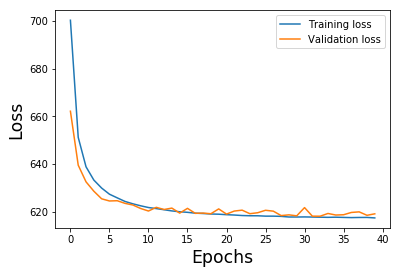

In [15]:
# Train VAE on new compendium data
train_vae_modules.train_vae(config_filename, normalized_compendium_filename)